<a href="https://colab.research.google.com/github/karthikpuranik11/Hope-Speech-Detection-/blob/main/Malayalam/Bert-base-cased%2BbiLSTM_Malayalam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3.3.1

     |████████████████████████████████| 1.1MB 12.2MB/s 
     |████████████████████████████████| 1.2MB 58.5MB/s 
     |████████████████████████████████| 890kB 53.0MB/s 
     |████████████████████████████████| 3.0MB 57.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=8d3050463c59581d05eb9f36150a88f905b02e90cbe68071e16ec764554bbcf0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
train=pd.read_csv('/content/malayalam_hope_train.tsv', header=None, names=['tweets','label'], sep="\t")
train['labels']=LabelEncoder().fit_transform(train['label'])
train=train.drop(columns='label')
train

,tweets,labels
0,@arya s nair may be athile karthikayude charct...,1
1,വാങ്ങിയത് എന്ത് കുന്തം ആയാലും കളയാൻ പറ്റില്ലല്...,1
2,മാറുമറയ്ക്കാൻ നടത്തിയ സമരം ഒരു previlege issue...,0
3,ഇഷാനെ കൂടുതല് കെട്ടിപിടിക്കേണ്ട ഞങ്ങൾക്കറിയാം ...,1
4,ഇന്ത്യ ഇസ്‌ലാമിക രാജ്യമല്ല.. ഇന്ത്യൻ ഭരണഘടന മാ...,0
...,...,...
8559,Evan eatha eee pottan oru vivaravumilla,1
8560,Ithinu pakaramayi upayogikkan pattunna Indian ...,1
8561,സാറിന് നല്ലത് വരട്ടെ,1
8562,ഇങ്ങനത്തെ നല്ല നല്ല അറിവുകൾ പറഞ്ഞു തരുന്ന ഈ ഡോ...,0


In [3]:
val=pd.read_csv('/content/malayalam_hope_test.csv', sep=";")
val['labels']=LabelEncoder().fit_transform(val['label'])
val['tweets']=val['text']
val=val.drop(columns=['label','Unnamed: 2','text'])
val

,labels,tweets
0,1,അതെ അണപൊട്ടി ഒഴുകുകയാണ്
1,1,കെവിൻ avde pettupoyi🤣🤣🤣
2,1,@my voice ullup illa daaa tayoli ath kond alle...
3,2,@Albin Baiju
4,2,I respect you..
...,...,...
1066,1,ചേട്ടാ അതിന് ഇവിടെ ആരാണ് ഇന്ത്യൻ മൊബൈൽ റിവ്യൂ ...
1067,2,@surya ishaan
1068,1,ഏതാണ് ആ മൂലയിൽ ഇരിക്കുന്ന അപ്പൂപ്പൻ
1069,1,ഏതാ ആ ചൊമന്ന ടി ഷർട്ടിന് മേൽ കോട്ടിട്ട വവ്വാൽ...


In [4]:

import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [5]:
 
print('Training set size:',train.shape)
#Uncomment the next line when we have the test data
#print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (8564, 2)
validation set size: (1071, 2)


In [6]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.labels.values),
                                                  train.labels.values)
class_weights

array([1.71143086, 0.46005909, 4.13121081])

In [7]:

def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      text = df.tweets.to_numpy(),
      label = df.labels.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [8]:
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [9]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

In [10]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [11]:
import torch
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('bert-base-multilingual-cased')
    self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
    self.linear = nn.Linear(256*2, 128)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.4)
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.auto(input_ids, 
               attention_mask=attention_mask)

    # sequence_output has the following shape: (batch_size, sequence_length, 768)
    lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
    hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
    linear_output = self.linear(lstm_output[:,-1].view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification

    return linear_output

In [12]:
model = RFClassifier(3)
model = model.to(device)

In [13]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [14]:

def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [15]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [16]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [17]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'bert-base-multilingual-cased.bin')
    best_accuracy = val_acc

Epoch: 01 | Epoch Time: 3m 28s
Train Loss 0.7363469670735189 accuracy 0.757006071929005
Val Loss 0.4910162380513023 accuracy 0.8141923436041083

Epoch: 02 | Epoch Time: 3m 29s
Train Loss 0.39658138823153366 accuracy 0.8441148995796356
Val Loss 0.41465364133610444 accuracy 0.8338001867413632

Epoch: 03 | Epoch Time: 3m 29s
Train Loss 0.28123718664161307 accuracy 0.8938580102755721
Val Loss 0.4272690450443941 accuracy 0.838468720821662

Epoch: 04 | Epoch Time: 3m 29s
Train Loss 0.21238003853263696 accuracy 0.9264362447454461
Val Loss 0.4369024537941989 accuracy 0.8552754435107377

Epoch: 05 | Epoch Time: 3m 30s
Train Loss 0.16495661079577767 accuracy 0.9469873890705277
Val Loss 0.4690037470530061 accuracy 0.8515406162464987



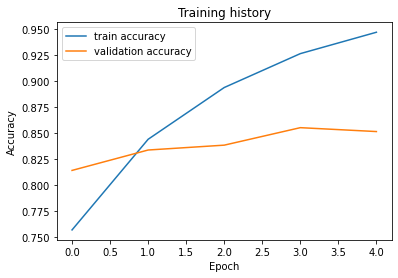

In [18]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1]);

In [19]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

0.8515406162464987

In [20]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [21]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

In [22]:
class_name = ['Hope_speech','Non_hope_speech','not-Malayalam']

In [23]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0, digits=4))

                 precision    recall  f1-score   support

    Hope_speech     0.7024    0.6082    0.6519       194
Non_hope_speech     0.8838    0.9214    0.9022       776
  not-Malayalam     0.8404    0.7822    0.8103       101

       accuracy                         0.8515      1071
      macro avg     0.8089    0.7706    0.7881      1071
   weighted avg     0.8469    0.8515    0.8482      1071



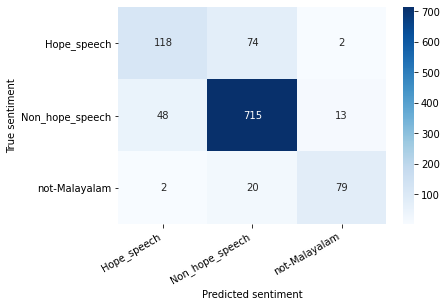

In [24]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)